# Protein Exploration Notebook

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import random
from sklearn.inspection import permutation_importance


def set_random_seed(seed=0):
  np.random.seed(seed)
  random.seed(seed)


set_random_seed(seed=42)

# Load Datasets

In [2]:
#Load Datasets

protein_df = pd.read_csv('../data/raw/ProteinAndPathologyQuantifications.csv')
Donor_df = pd.read_csv('../data/raw/DonorInformation.csv')
Stains_df = pd.read_csv('../data/raw/DescriptionOfStains.csv')
gene_expression_df = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/fpkm_table_normalized.csv')
gene_expression_unnormalized_df = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/fpkm_table_unnormalized.csv')
columns_samples_df = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/columns-samples.csv')
rows_genes_df = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')
gene_counts_df = pd.read_csv('../data/interim/ct_matrix.csv')


In [3]:
pd.set_option('display.max_colwidth', None)

Stains_df.head()

,api_class_name,internal_name,description,treatment_id,full_name,gene_id,method,display_name,long_display_name
0,ApiTbiDonorMetric,ihc_a_beta,Percentage of area covered by Aβ immunreactivity on fresh frozen tissue (25μm); identifies both Aβ40 and Aβ42.,300239718.0,Beta-amyloid immunohistochemistry (fresh frozen tissue): areal density,NaN,IHC: Fresh Frozen,Aβ(fresh),Aβ IHC density (fresh)
1,TbiNonquantifiedImageStains,h_e_lfb_ffpe,Hematoxylin identifies cell nuclei; Eosin stains cytoplasm and some cytoplasmic inclusions; Luxol Fast Blue stains myelin in tissue (5 μm).,471133394.0,Hematoxylin and eosin-Luxol Fast Blue stains,NaN,"Formalin Fixed, Paraffin Embedded",H&E-LFB(FFPE),H&E-LFB stain (FFPE)
2,ApiTbiDonorMetric,ihc_a_syn,Percentage of area covered by α-synuclein immunreactivity on fresh frozen tissue (25μm); identifies Lewy bodies and Lewy neurites.,300239725.0,Alpha-synuclein immunohistochemistry (fresh frozen tissue): areal density,NaN,IHC: Fresh Frozen,α-syn(fresh),α-syn IHC density (fresh)
3,ApiTbiDonorDetail,root_specimen_external_name,UW autopsy number,NaN,Top Specimen External Name,NaN,NaN,NaN,NaN
4,ApiTbiDonorMetric,ifn_g_pg_per_mg,"A prototype pro-inflammatory cytokine, critical for innate and adaptive immunity against viral and some bacterial infection via activation of macrophages and induction of class II MHC expression.",NaN,Interferon-gamma,NaN,Luminex,IFNγ,IFNγ protein quant.


In [4]:
Stains_df['internal_name'].unique()
#List of internal names from stains dataset

array(['ihc_a_beta', 'h_e_lfb_ffpe', 'ihc_a_syn',
       'root_specimen_external_name', 'ifn_g_pg_per_mg', 'race', 'name',
       'ish_aqp4', 'ish_slc17a7', 'ever_tbi_w_loc', 'rantes_pg_per_mg',
       'ihc_tau2_ffpe', 'external_donor_name', 'isoprostane_pg_per_mg',
       'act_demented', 'bdnf_pg_per_mg', 'ptau_over_tau_ratio',
       'ish_slc6a1', 'ptau_ng_per_mg', 'ish_mobp', 'mip_1a_pg_per_mg',
       'il_4_pg_per_mg', 'pmi_hrs', 'ab42_over_ab40_ratio',
       'ihc_a_beta_ffpe', 'ab42_pg_per_mg', 'mcp_1_pg_per_mg',
       'nincds_arda_diagnosis', 'ihc_at8', 'education_years',
       'apo_e4_allele', 'nissl', 'longest_loc_duration', 'donor_id',
       'ab40_pg_per_mg', 'ihc_iba1_ffpe', 'ihc_a_syn_ffpe', 'ish_reln',
       'num_tbi_w_loc', 'dsm_iv_clinical_diagnosis',
       'ab40_over_ab42_ratio', 'control_set', 'il_1b_pg_per_mg',
       'ihc_ptdp_43_ffpe', 'sex', 'cerad', 'il_7_pg_per_mg',
       'il_6_pg_per_mg', 'ihc_at8_ffpe', 'tau_ng_per_mg', 'nia_reagan',
       'a_syn_pg_per_

In [5]:
protein_df

,donor_id,donor_name,structure_id,structure_acronym,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,...,il_4_pg_per_mg,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg
0,309335467,H14.09.030,10557,FWM,0.000078,0.002358,0.001137,0.000110,0.001259,0.008335,...,2.68,15.99,0.736100,0.122288,1.47,20.78,5.03736,9.38,11.78,523.292251
1,309335480,H14.09.043,10208,PCx,0.000063,0.002762,0.001272,0.000164,0.002354,0.005047,...,3.02,24.04,0.669094,0.111962,1.44,40.40,4.95462,8.10,45.02,81.493875
2,309335493,H14.09.056,10557,FWM,0.000064,0.003468,0.013787,0.016023,0.001708,0.007365,...,0.80,129.80,0.736100,0.091084,0.54,46.88,5.88409,27.00,15.82,470.734514
3,326765668,H14.09.081,10557,FWM,0.000049,0.003035,0.001707,0.000137,0.001729,0.004046,...,1.30,15.16,8.995575,0.054076,0.76,10.34,16.13524,8.06,24.22,568.368571
4,326765668,H14.09.081,10235,TCx,0.000080,0.002088,0.004489,0.000062,0.001513,0.015809,...,0.00,17.90,95.931000,0.030000,1.22,21.38,0.03000,10.52,23.72,438.863263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,326765653,H14.09.066,10208,PCx,0.000046,0.001989,0.000533,0.000082,0.001130,0.003128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,309335452,H14.09.015,10294,HIP,0.000089,0.001918,0.004685,0.000923,0.001181,0.003483,...,0.00,5.94,0.574500,0.248816,0.00,7.16,2.94819,17.82,1.38,0.054413
374,309335489,H14.09.052,10294,HIP,0.000066,0.002275,0.006337,0.009560,0.001395,0.001710,...,0.00,7.62,0.900050,0.183510,0.00,3.14,10.56419,21.96,0.60,0.181375
375,309335458,H14.09.021,10208,PCx,0.000793,0.004384,0.001266,0.000093,0.002505,0.009795,...,0.02,4.88,0.444250,0.045202,0.00,7.20,2.83064,0.00,12.46,205.886650


In [6]:
#set list of donor ids

donor_ids = protein_df.donor_id.unique()

In [7]:
len(donor_ids)

107

In [8]:
Donor_df

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1
1,326765656,H14.09.069,95-99,M,N,17,12,1-2 min,2,1,No Dementia,26,No Dementia,Y,White,Not Hispanic,No Dementia,5,2
2,326765654,H14.09.067,85,M,Y,10,72,< 10 sec,3,1,Vascular,25,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,2
3,467056391,H15.09.103,90-94,F,N,11,87,< 10 sec,0,1,No Dementia,52,No Dementia,Y,White,Not Hispanic,No Dementia,4,0
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,309335458,H14.09.021,88,M,N,12,18,> 1 hr,0,1,Alzheimer's Disease Type,21,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,1,1
103,309335462,H14.09.025,84,M,N,16,23,10 min - 1 hr,0,2,Alzheimer's Disease Type,40,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,0,0
104,309335454,H14.09.017,79,M,N,16,13,< 10 sec,2,3,No Dementia,44,No Dementia,Y,White,Not Hispanic,No Dementia,3,2
105,309335486,H14.09.049,95-99,M,N,21,18,3-5 min,1,1,No Dementia,12,No Dementia,Y,White,Not Hispanic,No Dementia,3,1


In [9]:
# Examine the distribution of diagnosis among donors

In [10]:
Donor_df.act_demented.unique()

array(['No Dementia', 'Dementia'], dtype=object)

In [11]:
Donor_df.dsm_iv_clinical_diagnosis.unique()

array(['No Dementia', 'Vascular', "Alzheimer's Disease Type",
       'Multiple Etiologies', 'Other or Unknown Cause', 'Other Medical'],
      dtype=object)

In [12]:
Donor_df.nincds_arda_diagnosis.unique()

array(['No Dementia', 'Dementia, Type Unknown',
       "Possible Alzheimer'S Disease", "Probable Alzheimer'S Disease"],
      dtype=object)

In [13]:
def graph_diagnosis(data, diagnosis):
    from collections import Counter

    # Your data

    # Count occurrences of each item
    counter = Counter(data)

    # Extract categories and counts
    categories = list(counter.keys())
    counts = list(counter.values())

    # Create a bar chart
    plt.bar(categories, counts, color='skyblue')

    # Add labels and title
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Diagnosis Counts ({})'.format(diagnosis))

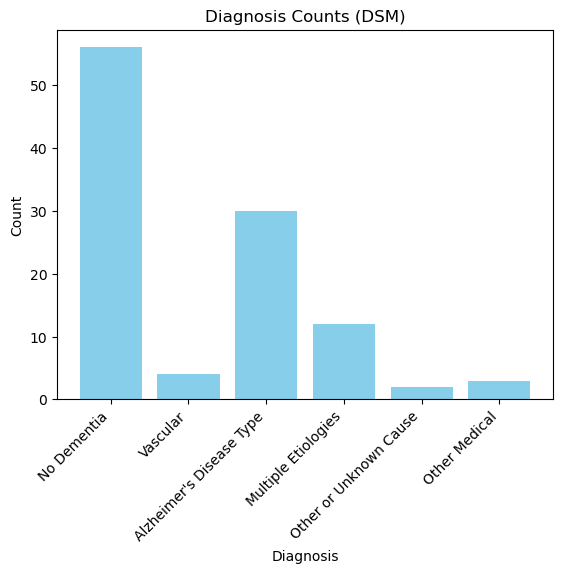

In [14]:
data = Donor_df.dsm_iv_clinical_diagnosis
graph_diagnosis(data, 'DSM')

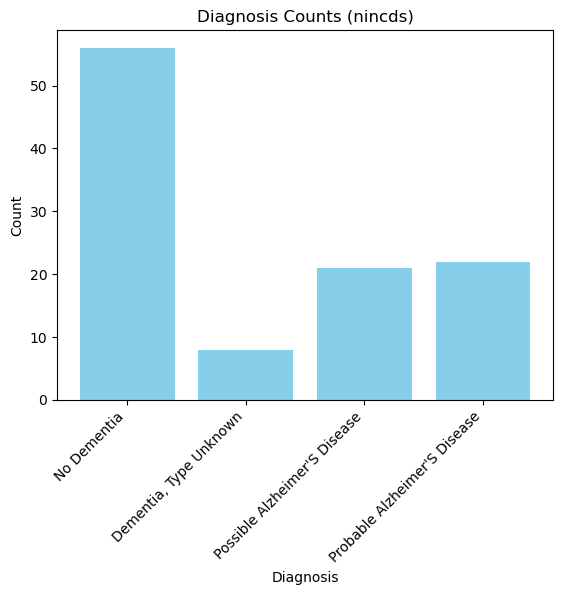

In [15]:
data = Donor_df.nincds_arda_diagnosis
graph_diagnosis(data, 'nincds')

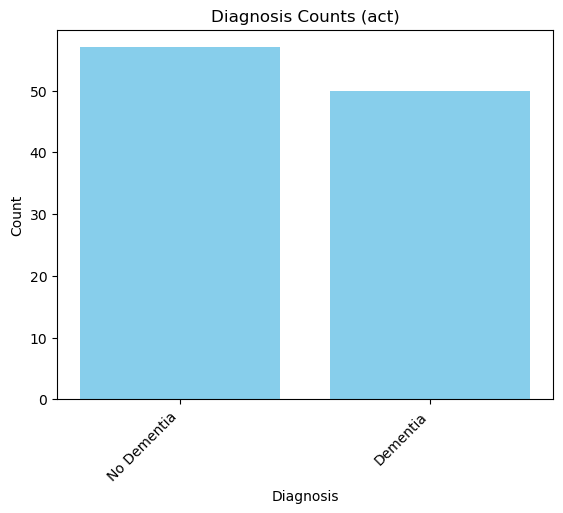

In [16]:
data = Donor_df.act_demented
graph_diagnosis(data, 'act')

In [17]:
# We will continue the analysis using the 'act_dementia' diagnosis.
# These classes are fairly and we will use accuracy as a measure of performance for the evaluating 
# classification models.

In [18]:
# Create df of donors ids and corresponding diagnosis, this will be used to map to the proteins data samples
donor_labels_df = Donor_df[['donor_id','act_demented']]

In [19]:
donor_labels_df

,donor_id,act_demented
0,326765665,No Dementia
1,326765656,No Dementia
2,326765654,Dementia
3,467056391,No Dementia
4,309335447,Dementia
...,...,...
102,309335458,Dementia
103,309335462,Dementia
104,309335454,No Dementia
105,309335486,No Dementia


In [20]:
# Map donor_labels_df to protein_df so each sample will be associated with the appropriate diagnosis 
donor_labels_dict = donor_labels_df.set_index('donor_id')['act_demented'].to_dict()
protein_df['dementia_status'] = protein_df['donor_id'].map(donor_labels_dict)

In [21]:
#Examine protein_df to ensure labels properly populated
protein_df

,donor_id,donor_name,structure_id,structure_acronym,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,...,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg,dementia_status
0,309335467,H14.09.030,10557,FWM,0.000078,0.002358,0.001137,0.000110,0.001259,0.008335,...,15.99,0.736100,0.122288,1.47,20.78,5.03736,9.38,11.78,523.292251,No Dementia
1,309335480,H14.09.043,10208,PCx,0.000063,0.002762,0.001272,0.000164,0.002354,0.005047,...,24.04,0.669094,0.111962,1.44,40.40,4.95462,8.10,45.02,81.493875,Dementia
2,309335493,H14.09.056,10557,FWM,0.000064,0.003468,0.013787,0.016023,0.001708,0.007365,...,129.80,0.736100,0.091084,0.54,46.88,5.88409,27.00,15.82,470.734514,Dementia
3,326765668,H14.09.081,10557,FWM,0.000049,0.003035,0.001707,0.000137,0.001729,0.004046,...,15.16,8.995575,0.054076,0.76,10.34,16.13524,8.06,24.22,568.368571,No Dementia
4,326765668,H14.09.081,10235,TCx,0.000080,0.002088,0.004489,0.000062,0.001513,0.015809,...,17.90,95.931000,0.030000,1.22,21.38,0.03000,10.52,23.72,438.863263,No Dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,326765653,H14.09.066,10208,PCx,0.000046,0.001989,0.000533,0.000082,0.001130,0.003128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dementia
373,309335452,H14.09.015,10294,HIP,0.000089,0.001918,0.004685,0.000923,0.001181,0.003483,...,5.94,0.574500,0.248816,0.00,7.16,2.94819,17.82,1.38,0.054413,No Dementia
374,309335489,H14.09.052,10294,HIP,0.000066,0.002275,0.006337,0.009560,0.001395,0.001710,...,7.62,0.900050,0.183510,0.00,3.14,10.56419,21.96,0.60,0.181375,No Dementia
375,309335458,H14.09.021,10208,PCx,0.000793,0.004384,0.001266,0.000093,0.002505,0.009795,...,4.88,0.444250,0.045202,0.00,7.20,2.83064,0.00,12.46,205.886650,Dementia


In [22]:
#Check the distribution of Dementia in Protein samples dataset
print('No Dementia: ', len(protein_df[protein_df['dementia_status']=='No Dementia']))
print('Dementia: ', len(protein_df[protein_df['dementia_status']=='Dementia']))

No Dementia:  197
Dementia:  180


# Handling Missing Data

In [23]:
#check for Nan
total_nan_count = protein_df.isna().sum()


In [24]:
total_nan_count

donor_id                   0
donor_name                 0
structure_id               0
structure_acronym          0
ihc_a_syn                  0
ihc_tau2_ffpe             21
ihc_at8_ffpe              16
ihc_at8                    0
ihc_ptdp_43_ffpe          15
ihc_a_beta_ffpe           22
ihc_a_beta                 0
ihc_iba1_ffpe             14
ihc_gfap_ffpe             32
ptau_ng_per_mg            45
vegf_pg_per_mg            45
ab42_over_ab40_ratio      50
tnf_a_pg_per_mg           45
tau_ng_per_mg             51
il_10_pg_per_mg           45
isoprostane_pg_per_mg    239
il_6_pg_per_mg            45
il_1b_pg_per_mg           45
ptau_over_tau_ratio       51
il_4_pg_per_mg            45
rantes_pg_per_mg          45
ab40_pg_per_mg            45
a_syn_pg_per_mg           56
ifn_g_pg_per_mg           45
mcp_1_pg_per_mg           45
bdnf_pg_per_mg            54
mip_1a_pg_per_mg          45
il_7_pg_per_mg            45
ab42_pg_per_mg            45
dementia_status            0
dtype: int64

In [25]:
# Process dataframe by Dropping Nan
# - drop isoprostane_pg_per_mg because missing most of the data (63% of samples missing isoprostane data)
# - dropna for remaining columns (will still represent >70% of the samples)

protein_df_drop_cleaned = protein_df.drop('isoprostane_pg_per_mg',axis=1)
protein_df_drop_cleaned.dropna(inplace = True)

In [26]:
# Check for Nan after cleaning
total_nan_count = protein_df_drop_cleaned.isna().sum()
total_nan_count

donor_id                0
donor_name              0
structure_id            0
structure_acronym       0
ihc_a_syn               0
ihc_tau2_ffpe           0
ihc_at8_ffpe            0
ihc_at8                 0
ihc_ptdp_43_ffpe        0
ihc_a_beta_ffpe         0
ihc_a_beta              0
ihc_iba1_ffpe           0
ihc_gfap_ffpe           0
ptau_ng_per_mg          0
vegf_pg_per_mg          0
ab42_over_ab40_ratio    0
tnf_a_pg_per_mg         0
tau_ng_per_mg           0
il_10_pg_per_mg         0
il_6_pg_per_mg          0
il_1b_pg_per_mg         0
ptau_over_tau_ratio     0
il_4_pg_per_mg          0
rantes_pg_per_mg        0
ab40_pg_per_mg          0
a_syn_pg_per_mg         0
ifn_g_pg_per_mg         0
mcp_1_pg_per_mg         0
bdnf_pg_per_mg          0
mip_1a_pg_per_mg        0
il_7_pg_per_mg          0
ab42_pg_per_mg          0
dementia_status         0
dtype: int64

In [27]:
# protein_df_drop_cleaned has samples with corresponding dementia labels and no missing values. 
# Represents total of 279 samples from original 377 samples (74%)
protein_df_drop_cleaned

,donor_id,donor_name,structure_id,structure_acronym,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,...,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg,dementia_status
0,309335467,H14.09.030,10557,FWM,0.000078,0.002358,0.001137,0.000110,0.001259,0.008335,...,15.99,0.736100,0.122288,1.47,20.78,5.03736,9.38,11.78,523.292251,No Dementia
1,309335480,H14.09.043,10208,PCx,0.000063,0.002762,0.001272,0.000164,0.002354,0.005047,...,24.04,0.669094,0.111962,1.44,40.40,4.95462,8.10,45.02,81.493875,Dementia
2,309335493,H14.09.056,10557,FWM,0.000064,0.003468,0.013787,0.016023,0.001708,0.007365,...,129.80,0.736100,0.091084,0.54,46.88,5.88409,27.00,15.82,470.734514,Dementia
3,326765668,H14.09.081,10557,FWM,0.000049,0.003035,0.001707,0.000137,0.001729,0.004046,...,15.16,8.995575,0.054076,0.76,10.34,16.13524,8.06,24.22,568.368571,No Dementia
4,326765668,H14.09.081,10235,TCx,0.000080,0.002088,0.004489,0.000062,0.001513,0.015809,...,17.90,95.931000,0.030000,1.22,21.38,0.03000,10.52,23.72,438.863263,No Dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,326765668,H14.09.081,10294,HIP,0.000122,0.006376,0.026056,0.025917,0.001646,0.009597,...,4.56,5.170612,0.115779,0.00,3.50,11.53213,19.72,1.38,457.402238,No Dementia
373,309335452,H14.09.015,10294,HIP,0.000089,0.001918,0.004685,0.000923,0.001181,0.003483,...,5.94,0.574500,0.248816,0.00,7.16,2.94819,17.82,1.38,0.054413,No Dementia
374,309335489,H14.09.052,10294,HIP,0.000066,0.002275,0.006337,0.009560,0.001395,0.001710,...,7.62,0.900050,0.183510,0.00,3.14,10.56419,21.96,0.60,0.181375,No Dementia
375,309335458,H14.09.021,10208,PCx,0.000793,0.004384,0.001266,0.000093,0.002505,0.009795,...,4.88,0.444250,0.045202,0.00,7.20,2.83064,0.00,12.46,205.886650,Dementia


In [28]:
# Process data by imputing Mean/Median
protein_df_mean_cleaned = protein_df.drop('isoprostane_pg_per_mg',axis=1)
protein_df_median_cleaned = protein_df.drop('isoprostane_pg_per_mg',axis=1)

columns_with_nans = protein_df_mean_cleaned.columns[protein_df_mean_cleaned.isna().any()].tolist()
#columns_with_nans

In [29]:
for nan_column in columns_with_nans:
    protein_df_mean_cleaned[nan_column].fillna(protein_df_mean_cleaned[nan_column].mean(), inplace=True)
    protein_df_median_cleaned[nan_column].fillna(protein_df_mean_cleaned[nan_column].median(), inplace=True)


In [30]:
total_nan_count = protein_df_mean_cleaned.isna().sum()
total_nan_count


donor_id                0
donor_name              0
structure_id            0
structure_acronym       0
ihc_a_syn               0
ihc_tau2_ffpe           0
ihc_at8_ffpe            0
ihc_at8                 0
ihc_ptdp_43_ffpe        0
ihc_a_beta_ffpe         0
ihc_a_beta              0
ihc_iba1_ffpe           0
ihc_gfap_ffpe           0
ptau_ng_per_mg          0
vegf_pg_per_mg          0
ab42_over_ab40_ratio    0
tnf_a_pg_per_mg         0
tau_ng_per_mg           0
il_10_pg_per_mg         0
il_6_pg_per_mg          0
il_1b_pg_per_mg         0
ptau_over_tau_ratio     0
il_4_pg_per_mg          0
rantes_pg_per_mg        0
ab40_pg_per_mg          0
a_syn_pg_per_mg         0
ifn_g_pg_per_mg         0
mcp_1_pg_per_mg         0
bdnf_pg_per_mg          0
mip_1a_pg_per_mg        0
il_7_pg_per_mg          0
ab42_pg_per_mg          0
dementia_status         0
dtype: int64

In [31]:
protein_df_mean_cleaned

,donor_id,donor_name,structure_id,structure_acronym,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,...,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg,dementia_status
0,309335467,H14.09.030,10557,FWM,0.000078,0.002358,0.001137,0.000110,0.001259,0.008335,...,15.990000,0.736100,0.122288,1.470000,20.780000,5.037360,9.380000,11.780000,523.292251,No Dementia
1,309335480,H14.09.043,10208,PCx,0.000063,0.002762,0.001272,0.000164,0.002354,0.005047,...,24.040000,0.669094,0.111962,1.440000,40.400000,4.954620,8.100000,45.020000,81.493875,Dementia
2,309335493,H14.09.056,10557,FWM,0.000064,0.003468,0.013787,0.016023,0.001708,0.007365,...,129.800000,0.736100,0.091084,0.540000,46.880000,5.884090,27.000000,15.820000,470.734514,Dementia
3,326765668,H14.09.081,10557,FWM,0.000049,0.003035,0.001707,0.000137,0.001729,0.004046,...,15.160000,8.995575,0.054076,0.760000,10.340000,16.135240,8.060000,24.220000,568.368571,No Dementia
4,326765668,H14.09.081,10235,TCx,0.000080,0.002088,0.004489,0.000062,0.001513,0.015809,...,17.900000,95.931000,0.030000,1.220000,21.380000,0.030000,10.520000,23.720000,438.863263,No Dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,326765653,H14.09.066,10208,PCx,0.000046,0.001989,0.000533,0.000082,0.001130,0.003128,...,42.729658,33.144032,0.154011,0.632349,26.619313,4.845273,25.512727,14.670538,258.773277,Dementia
373,309335452,H14.09.015,10294,HIP,0.000089,0.001918,0.004685,0.000923,0.001181,0.003483,...,5.940000,0.574500,0.248816,0.000000,7.160000,2.948190,17.820000,1.380000,0.054413,No Dementia
374,309335489,H14.09.052,10294,HIP,0.000066,0.002275,0.006337,0.009560,0.001395,0.001710,...,7.620000,0.900050,0.183510,0.000000,3.140000,10.564190,21.960000,0.600000,0.181375,No Dementia
375,309335458,H14.09.021,10208,PCx,0.000793,0.004384,0.001266,0.000093,0.002505,0.009795,...,4.880000,0.444250,0.045202,0.000000,7.200000,2.830640,0.000000,12.460000,205.886650,Dementia


In [32]:
# Protein groups
# There are 28 different protein measures, however there are only 14 distinct proteins. 
# Some measures are different methods of measuring the same protein, for example ihc_a_syn is measuring the 
# stain area coverage for α-synuclein, while a_syn_pg_per_mg is measuring the concentration of a_syn_pg_per_mg

# Amyloid: ihc_a_beta, ab42_over_ab40_ratio, ihc_a_beta_ffpe, ab42_pg_per_mg, ab40_pg_per_mg
# α-synuclein:ihc_a_syn, a_syn_pg_per_mg
# interferon: ifn_g_pg_per_mg
# RANTES: rantes_pg_per_mg
# Tau: ihc_tau2_ffpe, ptau_over_tau_ratio, ptau_ng_per_mg, ihc_at8, ihc_at8_ffpe, tau_ng_per_mg
# Isoprostane: isoprostane_pg_per_mg
# BDNF: bdnf_pg_per_mg
# MIP-1a: mip_1a_pg_per_mg
# Interleukins: il_4_pg_per_mg, il_1b_pg_per_mg, il_7_pg_per_mg, il_6_pg_per_mg, il_10_pg_per_mg
# MCP-1: mcp_1_pg_per_mg
# IBA-1: ihc_iba1_ffpe
# phospho-TDP43: ihc_ptdp_43_ffpe
# GFAP:ihc_gfap_ffpe
# TNF: Tumor Necrosis Factor alpha

In [33]:
#View list of columns
columns = protein_df_drop_cleaned.columns
columns

Index(['donor_id', 'donor_name', 'structure_id', 'structure_acronym',
       'ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8',
       'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe',
       'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg',
       'ab42_over_ab40_ratio', 'tnf_a_pg_per_mg', 'tau_ng_per_mg',
       'il_10_pg_per_mg', 'il_6_pg_per_mg', 'il_1b_pg_per_mg',
       'ptau_over_tau_ratio', 'il_4_pg_per_mg', 'rantes_pg_per_mg',
       'ab40_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg',
       'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg',
       'il_7_pg_per_mg', 'ab42_pg_per_mg', 'dementia_status'],
      dtype='object')

In [34]:
# columns to keep for training
# dropping catergorical columns as well as donor_id/donor_name and dementia status

columns_keep_for_training = [
       'ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8',
       'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe',
       'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg',
       'ab42_over_ab40_ratio', 'tnf_a_pg_per_mg', 'tau_ng_per_mg',
       'il_10_pg_per_mg', 'il_6_pg_per_mg', 'il_1b_pg_per_mg',
       'ptau_over_tau_ratio', 'il_4_pg_per_mg', 'rantes_pg_per_mg',
       'ab40_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg',
       'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg',
       'il_7_pg_per_mg', 'ab42_pg_per_mg']

In [35]:
# Scale the data in preparation for use in ML models

x = protein_df_drop_cleaned.loc[:,columns_keep_for_training].values
x_min_max = MinMaxScaler().fit_transform(x) #Min Max Scaler
x_std_sclr = StandardScaler().fit_transform(x) #Standard Scaler

In [36]:
x_min_max.shape

(279, 28)

In [37]:
np.mean(x_min_max),np.std(x_min_max) #Check mean and std of the data

(0.16700139991204196, 0.21819012931448575)

In [38]:
np.mean(x_std_sclr),np.std(x_std_sclr) #Check mean and std of the data

(-9.436611474028469e-18, 1.0)

In [39]:
# Create a normalised protein df from min max scaled data

normalised_protein = pd.DataFrame(x_min_max,columns=columns_keep_for_training)
normalised_protein


,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,ihc_a_beta_ffpe,ihc_a_beta,ihc_iba1_ffpe,ihc_gfap_ffpe,ptau_ng_per_mg,...,il_4_pg_per_mg,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg
0,0.004851,0.070659,0.016041,0.000820,0.181651,0.098652,0.050317,0.140195,0.329684,0.079555,...,0.194485,0.047355,0.000641,0.040327,0.226852,0.079562,0.048526,0.011879,0.204941,0.816842
1,0.003883,0.085210,0.018517,0.001303,0.443239,0.050030,0.090170,0.295991,0.423883,0.043424,...,0.219158,0.071196,0.000573,0.036256,0.222222,0.154683,0.047726,0.010258,0.783229,0.127199
2,0.003968,0.110633,0.248443,0.142842,0.289009,0.084310,0.193490,0.333076,0.205040,0.237585,...,0.058055,0.384410,0.000641,0.028025,0.083333,0.179493,0.056716,0.034193,0.275226,0.734800
3,0.003007,0.095039,0.026515,0.001061,0.293991,0.035228,0.042059,0.276260,0.300421,0.165174,...,0.094340,0.044897,0.008942,0.013434,0.117284,0.039590,0.155861,0.010207,0.421364,0.887206
4,0.004955,0.060923,0.077627,0.000389,0.242403,0.209148,0.522897,0.251015,0.116882,0.260159,...,0.000000,0.053012,0.096314,0.003942,0.188272,0.081859,0.000097,0.013323,0.412665,0.685049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.007661,0.215311,0.473825,0.231140,0.274286,0.117303,0.100017,0.508987,0.275734,0.556902,...,0.000000,0.013505,0.005097,0.037760,0.000000,0.013401,0.111342,0.024973,0.024008,0.713989
275,0.005548,0.054834,0.081222,0.008080,0.163178,0.026916,0.112286,0.541738,0.397118,0.233870,...,0.000000,0.017592,0.000478,0.090210,0.000000,0.027414,0.028320,0.022567,0.024008,0.000073
276,0.004112,0.067683,0.111575,0.085165,0.214338,0.000694,0.071302,0.398251,0.309038,0.425571,...,0.000000,0.022567,0.000805,0.064463,0.000000,0.012022,0.101980,0.027810,0.010438,0.000271
277,0.050587,0.143587,0.018406,0.000667,0.479300,0.120231,0.231747,0.164625,0.428643,0.107656,...,0.001451,0.014452,0.000347,0.009936,0.000000,0.027567,0.027184,0.000000,0.216771,0.321375


# Conduct PCA on Standard Scaled Data

In [40]:
from sklearn.decomposition import PCA
pca_protein = PCA(n_components=2) #Set to 2 components for graphing
principalComponents_protein = pca_protein.fit_transform(x_std_sclr)

In [41]:
principal_protein_Df = pd.DataFrame(data = principalComponents_protein
             , columns = ['principal component 1', 'principal component 2'])

In [42]:
# Principal components dataframe of PC1 and PC2

principal_protein_Df

,principal component 1,principal component 2
0,-1.763604,-0.225923
1,-2.514442,-0.322716
2,-0.721718,1.057486
3,-1.390541,-0.194782
4,-1.525196,0.891506
...,...,...
274,3.737965,-0.898700
275,0.641916,-2.747660
276,1.953367,-2.824263
277,-1.210161,-0.403016


In [43]:
print('Explained variation per principal component: {}'.format(pca_protein.explained_variance_ratio_))


Explained variation per principal component: [0.21173342 0.11799016]


In [44]:
# Define function to see explained variation of n number of components

def PCA_function(components, x):
    pca_protein = PCA(n_components=components)
    principalComponents_protein = pca_protein.fit_transform(x)
    print('Explained variation per principal component: {}'.format(pca_protein.explained_variance_ratio_))
    return None

In [45]:
PCA_function(3,x_std_sclr) #3 PCs

Explained variation per principal component: [0.21173342 0.11799016 0.06706408]


In [46]:
PCA_function(4,x_std_sclr) # 4 PCs

Explained variation per principal component: [0.21173342 0.11799016 0.06706408 0.06643909]


In [47]:
# More than 2 principal components do not add any significant explaination of variation

In [48]:
# Reset index to match principal_protein_Df
protein_df_drop_cleaned.reset_index(inplace = True)

In [49]:
protein_df_drop_cleaned

,index,donor_id,donor_name,structure_id,structure_acronym,ihc_a_syn,ihc_tau2_ffpe,ihc_at8_ffpe,ihc_at8,ihc_ptdp_43_ffpe,...,rantes_pg_per_mg,ab40_pg_per_mg,a_syn_pg_per_mg,ifn_g_pg_per_mg,mcp_1_pg_per_mg,bdnf_pg_per_mg,mip_1a_pg_per_mg,il_7_pg_per_mg,ab42_pg_per_mg,dementia_status
0,0,309335467,H14.09.030,10557,FWM,0.000078,0.002358,0.001137,0.000110,0.001259,...,15.99,0.736100,0.122288,1.47,20.78,5.03736,9.38,11.78,523.292251,No Dementia
1,1,309335480,H14.09.043,10208,PCx,0.000063,0.002762,0.001272,0.000164,0.002354,...,24.04,0.669094,0.111962,1.44,40.40,4.95462,8.10,45.02,81.493875,Dementia
2,2,309335493,H14.09.056,10557,FWM,0.000064,0.003468,0.013787,0.016023,0.001708,...,129.80,0.736100,0.091084,0.54,46.88,5.88409,27.00,15.82,470.734514,Dementia
3,3,326765668,H14.09.081,10557,FWM,0.000049,0.003035,0.001707,0.000137,0.001729,...,15.16,8.995575,0.054076,0.76,10.34,16.13524,8.06,24.22,568.368571,No Dementia
4,4,326765668,H14.09.081,10235,TCx,0.000080,0.002088,0.004489,0.000062,0.001513,...,17.90,95.931000,0.030000,1.22,21.38,0.03000,10.52,23.72,438.863263,No Dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,370,326765668,H14.09.081,10294,HIP,0.000122,0.006376,0.026056,0.025917,0.001646,...,4.56,5.170612,0.115779,0.00,3.50,11.53213,19.72,1.38,457.402238,No Dementia
275,373,309335452,H14.09.015,10294,HIP,0.000089,0.001918,0.004685,0.000923,0.001181,...,5.94,0.574500,0.248816,0.00,7.16,2.94819,17.82,1.38,0.054413,No Dementia
276,374,309335489,H14.09.052,10294,HIP,0.000066,0.002275,0.006337,0.009560,0.001395,...,7.62,0.900050,0.183510,0.00,3.14,10.56419,21.96,0.60,0.181375,No Dementia
277,375,309335458,H14.09.021,10208,PCx,0.000793,0.004384,0.001266,0.000093,0.002505,...,4.88,0.444250,0.045202,0.00,7.20,2.83064,0.00,12.46,205.886650,Dementia


In [50]:
print(len(protein_df_drop_cleaned[protein_df_drop_cleaned['dementia_status']=='No Dementia']))
print(len(protein_df_drop_cleaned[protein_df_drop_cleaned['dementia_status']=='Dementia']))

144
135


<Figure size 640x480 with 0 Axes>

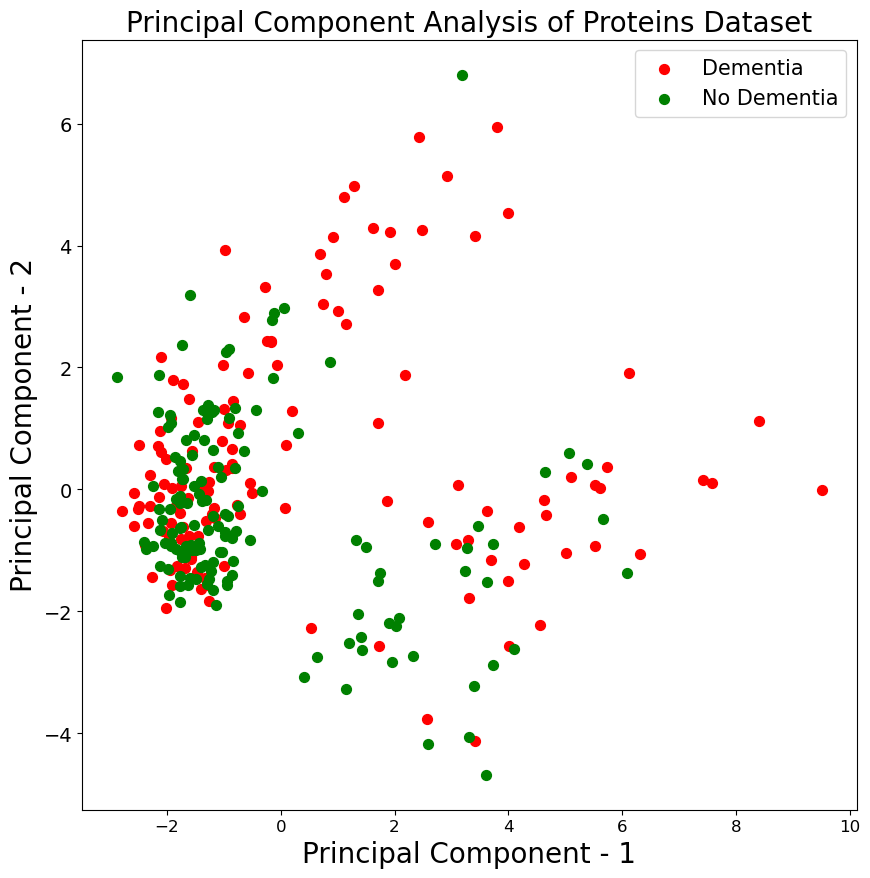

In [51]:
# Plot the PCA

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Proteins Dataset",fontsize=20)
targets = ['Dementia', 'No Dementia']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    #print(target)
    indicesToKeep = protein_df_drop_cleaned['dementia_status'] == target
    #print(indicesToKeep)
    plt.scatter(principal_protein_Df.loc[indicesToKeep, 'principal component 1']
               , principal_protein_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [52]:
#PCA does not appear to have good separation 

# Train Test Split on Donor Ids

In [53]:
#Since multiple samples could originate from a single donor, in order to not have the same donor sample
# in both the training and test sets. We will conduct Train and Test split based on unique donor_id

columns_keep_for_training = [
   'ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8',
   'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe',
   'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg',
   'ab42_over_ab40_ratio', 'tnf_a_pg_per_mg', 'tau_ng_per_mg',
   'il_10_pg_per_mg', 'il_6_pg_per_mg', 'il_1b_pg_per_mg',
   'ptau_over_tau_ratio', 'il_4_pg_per_mg', 'rantes_pg_per_mg',
   'ab40_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg',
   'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg',
   'il_7_pg_per_mg', 'ab42_pg_per_mg']

def train_test_split_donor_ids(dataframe, columns_keep_for_training, scaler=None):
    donor_ids = dataframe.donor_id.unique()
    np.random.seed(42)
    train_ids = np.random.choice(donor_ids, int(np.ceil(len(donor_ids) * 0.7)))
    test_ids = np.setdiff1d(donor_ids, train_ids)
    validate_ids = np.random.choice(test_ids, int(np.ceil(len(test_ids) * 0.5)))
    test_ids = np.setdiff1d(test_ids, validate_ids)
    
    drop_columns = ['donor_id','donor_name','structure_id','structure_acronym']
    train_df = dataframe[dataframe['donor_id'].isin(train_ids)].drop(columns = drop_columns)
    test_df = dataframe[dataframe['donor_id'].isin(test_ids)].drop(columns = drop_columns)
    val_df = dataframe[dataframe['donor_id'].isin(validate_ids)].drop(columns = drop_columns)
    

    
    if scaler == None:
        X_train = train_df[columns_keep_for_training]
        X_test = test_df[columns_keep_for_training]
        X_val = val_df[columns_keep_for_training]
        
    elif scaler == 'StandardScaler':
        X_train = StandardScaler().fit_transform(train_df[columns_keep_for_training])
        X_test = StandardScaler().fit_transform(test_df[columns_keep_for_training])
        X_val = StandardScaler().fit_transform(val_df[columns_keep_for_training])
        
    elif scaler == 'MinMaxScaler':
        X_train = MinMaxScaler().fit_transform(train_df[columns_keep_for_training])
        X_test = MinMaxScaler().fit_transform(test_df[columns_keep_for_training])
        X_val = MinMaxScaler().fit_transform(val_df[columns_keep_for_training])
        
    y_train = train_df['dementia_status']
    y_test = test_df['dementia_status']
    y_val = val_df['dementia_status']
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

# Initial Predictive Modeling


In [54]:
# Set X and y values Using Standard Scaler

# Use Nan dropped DataFrame
X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_donor_ids(protein_df_drop_cleaned, 
                                                                            columns_keep_for_training=columns_keep_for_training,
                                                                            scaler='StandardScaler')

# Use Nan Mean filled DataFrame
X_train_mean, X_val_mean, X_test_mean, y_train_mean, y_val_mean, y_test_mean = train_test_split_donor_ids(protein_df_mean_cleaned,
                                                                                                          columns_keep_for_training=columns_keep_for_training,
                                                                                                          scaler='StandardScaler')

# Use Nan Median filled DataFrame
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=columns_keep_for_training,
                                                                                                    scaler='StandardScaler')

In [55]:
print(len(X_train), len(X_val), len(X_test))


140 53 86


In [56]:
# X_train_med,y_train_med, X_val_med, y_val_med
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(kernel="linear", random_state=42, probability=True),
    SVC(kernel="rbf", random_state=42, probability=True),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42),
    DummyClassifier(strategy= 'most_frequent', random_state=42),
    HistGradientBoostingClassifier(random_state=42),
    LinearDiscriminantAnalysis()
]
model_names = ["Log_Reg", "DT", "RF", 'SVM_linear', "SVM_radial", "GaussianNB", 
               'Gradient_boosted', 'Dummy_most_freq', 'HistGradBst','LinDisAlys']

scores = {}
saved_models = {}
for name, model in zip(model_names, models):
    model.fit(X_train_med, y_train_med)
    saved_models[name] = model

    accuracy = model.score(X_val_med, y_val_med)
    
    scores[name] = accuracy

pd.Series(scores).sort_values(ascending=False).round(3)

RF                  0.720
GaussianNB          0.683
HistGradBst         0.683
SVM_radial          0.622
Gradient_boosted    0.585
Log_Reg             0.561
SVM_linear          0.537
LinDisAlys          0.537
DT                  0.488
Dummy_most_freq     0.488
dtype: float64

In [57]:
for name, model in zip(model_names, models):
    model.fit(X_train_mean, y_train_mean)
    saved_models[name] = model

    accuracy = model.score(X_val_mean, y_val_mean)
    
    scores[name] = accuracy

pd.Series(scores).sort_values(ascending=False).round(3)

GaussianNB          0.683
RF                  0.659
SVM_radial          0.610
HistGradBst         0.610
Log_Reg             0.585
SVM_linear          0.585
Gradient_boosted    0.585
LinDisAlys          0.524
Dummy_most_freq     0.488
DT                  0.378
dtype: float64

In [58]:
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    saved_models[name] = model

    accuracy = model.score(X_val, y_val)
    
    scores[name] = accuracy

pd.Series(scores).sort_values(ascending=False).round(3)

HistGradBst         0.679
RF                  0.566
LinDisAlys          0.566
SVM_linear          0.528
Log_Reg             0.509
Dummy_most_freq     0.509
DT                  0.491
SVM_radial          0.491
GaussianNB          0.491
Gradient_boosted    0.434
dtype: float64

In [59]:
# RandomForest on Median Filled missing data using StandardScaler gave the highest accuracy score of 0.71
# Other models with high scores
# - HistGradientBoostingClassifier (Median Filled - MinMax/Standard)
# - RandomForest (Mean Filled - MinMax)
# - GaussianNB (Mean/Median Filled - Standard)

# Test final against each of these Classifiers

# Feature Importance

In [60]:
def Plot_Feature_Importance_Funct(X_train, y_train, random=0): 
#Plotting feature importance based on mean decrease in purity

    
    feature_names = columns_keep_for_training
    forest = RandomForestClassifier(random_state=random)
    forest.fit(X_train,y_train)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    #print(importances)
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

ihc_at8                 0.066278
ihc_tau2_ffpe           0.066019
ihc_at8_ffpe            0.065210
ptau_ng_per_mg          0.060532
ihc_ptdp_43_ffpe        0.060335
ptau_over_tau_ratio     0.048012
ihc_a_beta_ffpe         0.045953
mcp_1_pg_per_mg         0.045461
ihc_gfap_ffpe           0.041326
ihc_a_beta              0.040776
ihc_a_syn               0.039996
ab42_pg_per_mg          0.039625
a_syn_pg_per_mg         0.037497
ab42_over_ab40_ratio    0.036423
rantes_pg_per_mg        0.035520
tau_ng_per_mg           0.034398
ihc_iba1_ffpe           0.033012
mip_1a_pg_per_mg        0.027710
il_6_pg_per_mg          0.024359
bdnf_pg_per_mg          0.024147
ab40_pg_per_mg          0.023399
vegf_pg_per_mg          0.023330
il_7_pg_per_mg          0.021234
il_10_pg_per_mg         0.017255
ifn_g_pg_per_mg         0.016546
tnf_a_pg_per_mg         0.014251
il_4_pg_per_mg          0.009105
il_1b_pg_per_mg         0.002292
dtype: float64

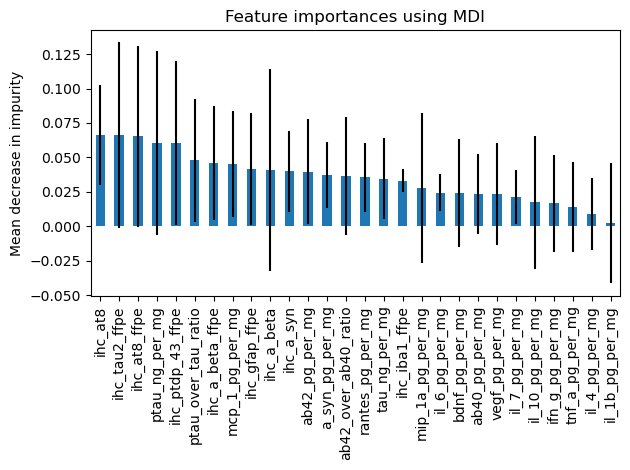

In [61]:
Plot_Feature_Importance_Funct(X_train_med,y_train_med,random=42)

ihc_at8                 0.081064
ihc_at8_ffpe            0.070263
ihc_tau2_ffpe           0.065752
ihc_ptdp_43_ffpe        0.062301
ptau_over_tau_ratio     0.055804
ihc_a_beta_ffpe         0.048580
mcp_1_pg_per_mg         0.041358
ptau_ng_per_mg          0.040865
ihc_gfap_ffpe           0.039088
tau_ng_per_mg           0.038671
ab42_pg_per_mg          0.037847
ihc_a_syn               0.037468
ihc_iba1_ffpe           0.036774
ab42_over_ab40_ratio    0.035754
mip_1a_pg_per_mg        0.034499
a_syn_pg_per_mg         0.034241
ihc_a_beta              0.033946
rantes_pg_per_mg        0.032959
vegf_pg_per_mg          0.025414
bdnf_pg_per_mg          0.021581
il_6_pg_per_mg          0.021104
ab40_pg_per_mg          0.020370
il_10_pg_per_mg         0.020176
il_7_pg_per_mg          0.018713
ifn_g_pg_per_mg         0.016179
tnf_a_pg_per_mg         0.014777
il_4_pg_per_mg          0.012701
il_1b_pg_per_mg         0.001752
dtype: float64

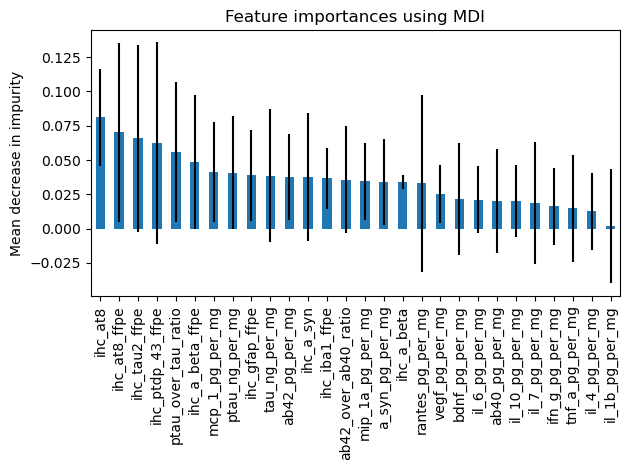

In [62]:
Plot_Feature_Importance_Funct(X_train_med,y_train_med,random=0)

ihc_at8                 0.071208
ihc_tau2_ffpe           0.070477
ihc_ptdp_43_ffpe        0.063660
ihc_at8_ffpe            0.057116
ihc_a_beta_ffpe         0.053971
ptau_over_tau_ratio     0.048945
ptau_ng_per_mg          0.048763
ihc_gfap_ffpe           0.046703
tau_ng_per_mg           0.039416
ab42_over_ab40_ratio    0.038804
ihc_a_beta              0.037188
mip_1a_pg_per_mg        0.037092
ihc_iba1_ffpe           0.036614
mcp_1_pg_per_mg         0.036274
ihc_a_syn               0.035068
ab42_pg_per_mg          0.034009
rantes_pg_per_mg        0.030550
a_syn_pg_per_mg         0.030245
il_6_pg_per_mg          0.028654
bdnf_pg_per_mg          0.023851
il_10_pg_per_mg         0.022346
ab40_pg_per_mg          0.022076
il_7_pg_per_mg          0.021942
vegf_pg_per_mg          0.020863
ifn_g_pg_per_mg         0.016104
tnf_a_pg_per_mg         0.012768
il_4_pg_per_mg          0.011156
il_1b_pg_per_mg         0.004137
dtype: float64

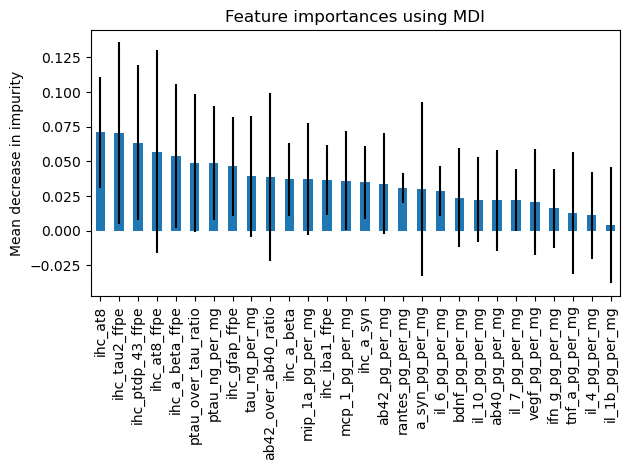

In [63]:
Plot_Feature_Importance_Funct(X_train_med,y_train_med,random=10)

In [64]:
# TAU related features have hightest importance: ihc_tau2_ffpe, ihc_at8_ffpe, ihc_at8, ptau_over_tau_ratio, ihc_ptdp_43_ffpe
# Features measured by concentration have lowest importance
# Selected Features based on feature importance

In [65]:
# Features
amyloid_features = ['ihc_a_beta', 'ab42_over_ab40_ratio', 'ihc_a_beta_ffpe', 'ab42_pg_per_mg', 'ab40_pg_per_mg']
tau_features = ['ihc_tau2_ffpe', 'ptau_over_tau_ratio', 'ptau_ng_per_mg', 'ihc_at8', 'ihc_at8_ffpe', 'tau_ng_per_mg']
IL_features = ['il_4_pg_per_mg', 'il_1b_pg_per_mg', 'il_7_pg_per_mg', 'il_6_pg_per_mg', 'il_10_pg_per_mg']
conc_features = [
    'ptau_ng_per_mg', 'vegf_pg_per_mg',
   'ab42_over_ab40_ratio', 'tnf_a_pg_per_mg', 'tau_ng_per_mg',
   'il_10_pg_per_mg', 'il_6_pg_per_mg', 'il_1b_pg_per_mg',
   'ptau_over_tau_ratio', 'il_4_pg_per_mg', 'rantes_pg_per_mg',
   'ab40_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg',
   'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg',
   'il_7_pg_per_mg', 'ab42_pg_per_mg']
IHC_features = ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8',
   'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe',
   'ihc_gfap_ffpe']

features_groups_list = [amyloid_features,tau_features,IL_features,conc_features,IHC_features]
group_names = ['amyloid_features','tau_features','IL_features','conc_features','IHC_features']


In [66]:
def algorithm_score(classifier, X_train, y_train, X_val, y_val):
    clf = classifier.fit(X_train, y_train)
    accuracy = clf.score(X_val, y_val)
    return accuracy

In [67]:
for feature_group, group_name in zip(features_groups_list, group_names):
    X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=feature_group,
                                                                                                    scaler='StandardScaler')

    print(group_name)
    print(algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med))
    print()


    
    

amyloid_features
0.4634146341463415

tau_features
0.5121951219512195

IL_features
0.5365853658536586

conc_features
0.5487804878048781

IHC_features
0.6585365853658537



In [68]:
# IHC features had the highest score

In [69]:
for feature_group, group_name in zip(features_groups_list, group_names):
    columns = [x for x in columns_keep_for_training if x not in feature_group]
    X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=columns,
                                                                                                    scaler='StandardScaler')
    print(group_name, ' Removed from Features.')
    print(algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med))
    print()


amyloid_features  Removed from Features.
0.7195121951219512

tau_features  Removed from Features.
0.5609756097560976

IL_features  Removed from Features.
0.7073170731707317

conc_features  Removed from Features.
0.6585365853658537

IHC_features  Removed from Features.
0.5487804878048781



In [70]:
# Removing tau and ihc features produces the largest drops in accuracy scores

In [116]:
# Add Tau and IHC features to compare with full features


tau_conc_features = ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8',
   'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe',
   'ihc_gfap_ffpe', 'ptau_over_tau_ratio', 'ptau_ng_per_mg', 'tau_ng_per_mg']

X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=tau_conc_features,
                                                                                                    scaler='StandardScaler')

algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)



0.6951219512195121

In [72]:
amyloid_IL_features = ['ihc_a_beta', 'ab42_over_ab40_ratio', 'ihc_a_beta_ffpe', 'ab42_pg_per_mg', 'ab40_pg_per_mg',
                      'il_4_pg_per_mg', 'il_1b_pg_per_mg', 'il_7_pg_per_mg', 'il_6_pg_per_mg', 'il_10_pg_per_mg']
columns = [x for x in columns_keep_for_training if x not in amyloid_IL_features]

X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=columns,
                                                                                                    scaler='StandardScaler')

print(columns)

print(algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med))

['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg', 'tnf_a_pg_per_mg', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 'a_syn_pg_per_mg', 'ifn_g_pg_per_mg', 'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 'mip_1a_pg_per_mg']
0.7317073170731707


In [73]:
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=columns_keep_for_training,
                                                                                                    scaler='StandardScaler')

algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)

0.7195121951219512

In [74]:
X_train_med.shape


(196, 28)

In [75]:
len(columns_keep_for_training)

28

In [76]:
#Dropping amyloid and IL features led to increase in accuracy score

# Recursive Feature Selection

In [82]:
def recursive_feature_elimination(num_features, feature_names, estimator, X_train, y_train, X_val, y_val):
    selected_features = []
    accuracy = None
    rfe = RFE(estimator=estimator, n_features_to_select=num_features) 
    rfe.fit(X_train, y_train)
    features_TF = list(rfe.support_)
    ranking = list(rfe.ranking_)
    #print()
    #print('Rankings: ',ranking)
    features_name = feature_names
    selected = zip(features_TF, features_name)
    selected_features = [y for x, y in selected if x == True]
    feature_rankings = zip(features_TF, ranking)
    selected_rankings = [y for x, y in feature_rankings if x == True]
    
    return selected_features


In [83]:
#Explore what 18 features RFE selects
#Compare with 18 feaures that were manually selected based on examination of feature importance

RFE_features = recursive_feature_elimination(18, columns_keep_for_training, RandomForestClassifier(random_state=42), 
                              X_train_med, y_train_med, X_val_med, y_val_med)

In [84]:
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_features,
                                                                                                    scaler='StandardScaler')
print(algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med))
print(RFE_features)

0.7560975609756098
['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'ab42_over_ab40_ratio', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 'a_syn_pg_per_mg', 'mcp_1_pg_per_mg', 'mip_1a_pg_per_mg', 'ab42_pg_per_mg']


In [85]:
accuracy_lst = []
features_lst = []
for i in range(28):
    
    X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=columns_keep_for_training,
                                                                                                    scaler='StandardScaler')
    features = recursive_feature_elimination(i+1, columns_keep_for_training, RandomForestClassifier(random_state=42), 
                              X_train_med, y_train_med, X_val_med, y_val_med)
    
    X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=features,
                                                                                                    scaler='StandardScaler')
    
    accuracy = algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)
    accuracy_lst.append(accuracy)
    features_lst.append(features)


In [86]:
#Show feature selections with scores >70
accuracy_features_lst = list(zip(accuracy_lst,features_lst))
for item in accuracy_features_lst:
    if item[0] >= 0.70:
        print('Num of features: ', len(item[1]))
        print(item)

Num of features:  17
(0.7073170731707317, ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'ab42_over_ab40_ratio', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 'a_syn_pg_per_mg', 'mcp_1_pg_per_mg', 'ab42_pg_per_mg'])
Num of features:  18
(0.7560975609756098, ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'ab42_over_ab40_ratio', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 'a_syn_pg_per_mg', 'mcp_1_pg_per_mg', 'mip_1a_pg_per_mg', 'ab42_pg_per_mg'])
Num of features:  21
(0.7195121951219512, ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg', 'ab42_over_ab40_ratio', 'tau_ng_per_mg', 'il_10_pg_per_mg', 'ptau

In [87]:
def graph_accuracy(num_features_range, accuracy_lst): #num_features_range [start,stop]
    x = range(num_features_range[0],num_features_range[1]+1)
    y = accuracy_lst
    
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Number of Features',fontsize=20)
    plt.ylabel('Accuracy Score',fontsize=20)
    plt.title("Accuracy Score by Number of Features",fontsize=20)

    plt.plot(x, y)
    
    return None

    

<Figure size 640x480 with 0 Axes>

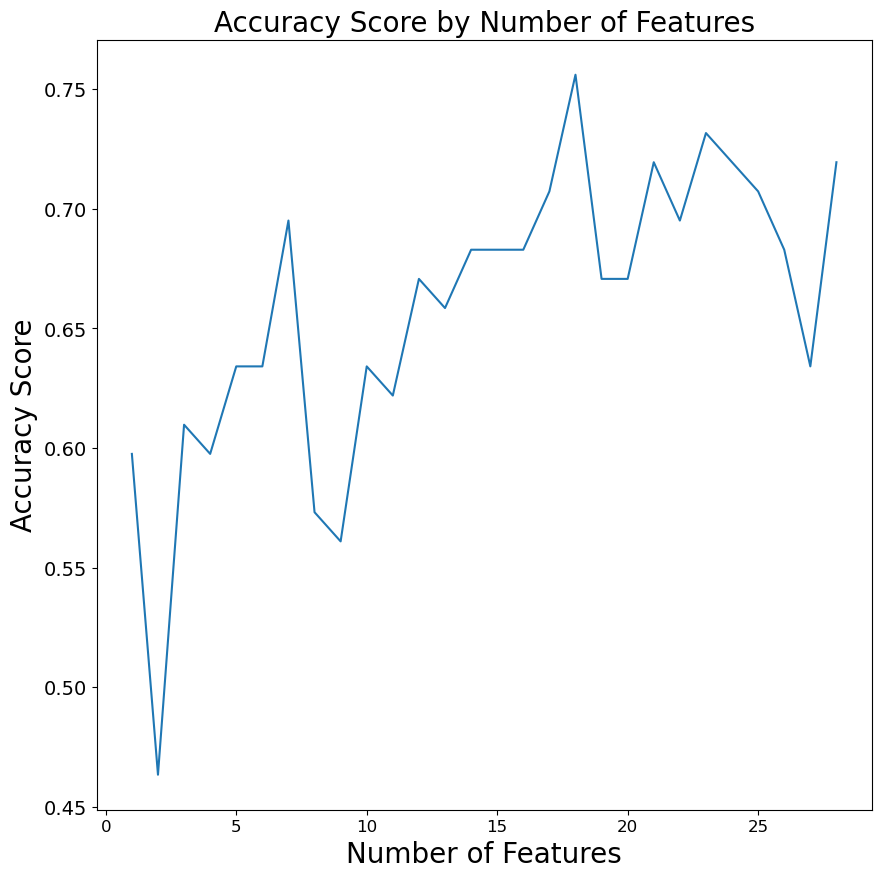

In [88]:
graph_accuracy([1,28], accuracy_lst) #num_features_range [start,stop]


In [89]:
# RFE was not very informative. No clear plateu to indicate optimal number of features. 


In [90]:
# Best accuracy from RFE was selection of 18 features with score of 0.7560975609756098

RFE_selected_features = ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 
                         'ihc_a_beta_ffpe', 'ihc_a_beta', 'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 
                         'ab42_over_ab40_ratio', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 
                         'a_syn_pg_per_mg', 'mcp_1_pg_per_mg', 'mip_1a_pg_per_mg', 'ab42_pg_per_mg']

Manual_selected_features = ['ihc_a_syn', 'ihc_tau2_ffpe', 'ihc_at8_ffpe', 'ihc_at8', 'ihc_ptdp_43_ffpe', 
                            'ihc_iba1_ffpe', 'ihc_gfap_ffpe', 'ptau_ng_per_mg', 'vegf_pg_per_mg', 
                            'tnf_a_pg_per_mg', 'tau_ng_per_mg', 'ptau_over_tau_ratio', 'rantes_pg_per_mg', 
                            'a_syn_pg_per_mg', 'ifn_g_pg_per_mg', 'mcp_1_pg_per_mg', 'bdnf_pg_per_mg', 
                            'mip_1a_pg_per_mg']


common_features = list(set(RFE_selected_features).intersection(set(Manual_selected_features)))
common_features

['ihc_at8_ffpe',
 'mcp_1_pg_per_mg',
 'ptau_over_tau_ratio',
 'ptau_ng_per_mg',
 'ihc_a_syn',
 'rantes_pg_per_mg',
 'ihc_ptdp_43_ffpe',
 'a_syn_pg_per_mg',
 'ihc_at8',
 'ihc_gfap_ffpe',
 'mip_1a_pg_per_mg',
 'tau_ng_per_mg',
 'ihc_tau2_ffpe',
 'ihc_iba1_ffpe']

In [91]:
different_features = set(RFE_selected_features).difference(set(Manual_selected_features)) 
different_features

{'ab42_over_ab40_ratio', 'ab42_pg_per_mg', 'ihc_a_beta', 'ihc_a_beta_ffpe'}

In [92]:
# Confusion Matrix Function
def algorithm_CM(classifier, X_train,y_train, X_val, y_val):
    clf = classifier.fit(X_train,y_train)
    preds = clf.predict(X_val)
    cm = confusion_matrix(y_val, preds)
    print(classifier)
    print(cm)
    
    return None


In [93]:
#CM and Accuracy based on manually selected features
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=Manual_selected_features,
                                                                                                    scaler='StandardScaler')


algorithm_CM(RandomForestClassifier(random_state=42), X_train_med, y_train_med, X_val_med, y_val_med)
algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)

RandomForestClassifier(random_state=42)
[[27 15]
 [ 7 33]]


0.7317073170731707

In [94]:
#CM and accuracy based on RFE selected features

X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_selected_features,
                                                                                                    scaler='StandardScaler')


algorithm_CM(RandomForestClassifier(random_state=42), X_train_med, y_train_med, X_val_med, y_val_med)
algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)


RandomForestClassifier(random_state=42)
[[28 14]
 [ 6 34]]


0.7560975609756098

In [95]:
#CM and Accuracy on shared features between manually selected and RFE selected
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=common_features,
                                                                                                    scaler='StandardScaler')
algorithm_CM(RandomForestClassifier(random_state=42), X_train_med, y_train_med, X_val_med, y_val_med)
algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_val_med, y_val_med)


RandomForestClassifier(random_state=42)
[[26 16]
 [11 29]]


0.6707317073170732

# Tuning the RandomForest Model

In [96]:
# Random Hyperparameter Grid
# Grid Search with Cross Validation
# Tutorial from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


In [97]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 5000, num = 1000)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1100, num = 110)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(1, 20)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 20)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [117]:
#random_grid

In [99]:
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_selected_features,
                                                                                                    scaler='StandardScaler')

rf = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_med, y_train_med)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/tonylan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
144 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tonylan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tonylan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/tonylan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  Fi

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290, 300, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 1, 1, 2, 2, 2,
                                                             3, 3, 4, 4, 4, 5,
                                                             5, 6, 6, 6, 7, 7,
                                                             7, 8, 8, 9, 9, 9,
                                                             10, 10, 11, 11, 11,
                                                             12, ...],
                                        'min_samples_split': [1, 1, 1, 2, 2, 2,
                                                              3, 3, 4, 4, 4, 5,
                                                              5, 6, 6, 6, 7, 7,
                                                              7, 8, 8, 9, 9, 9,
                                                              10, 10, 11, 11,
                                                              11, 12, ...],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         35, 40, 45, 50, 55, 60,
                                                         65, 70, 75, 80, 85, 90,
                                                         95, 100, 105, 110, 115,
                                                         120, 125, 130, 135,
                                                         140, 145, 150, ...]},
                   random_state=42, verbose=2)

In [100]:
rf_random.best_params_


{'n_estimators': 1665,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 640,
 'bootstrap': True}

In [101]:
{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [102]:
X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_selected_features,
                                                                                                    scaler='StandardScaler')


algorithm_score(RandomForestClassifier(random_state=42,n_estimators = 1400,min_samples_split = 10,
                                       min_samples_leaf = 2,max_features = 'sqrt', max_depth = 80,
                                       bootstrap = True), X_train_med,y_train_med, X_val_med, y_val_med)


0.7073170731707317

In [103]:
{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_selected_features,
                                                                                                    scaler='StandardScaler')


algorithm_score(RandomForestClassifier(random_state=42,n_estimators = 10,min_samples_split = 2,
                                       min_samples_leaf = 5,max_features = 'sqrt', max_depth = 80,
                                       bootstrap = True), X_train_med,y_train_med, X_val_med, y_val_med)

0.6707317073170732

In [104]:
{'n_estimators': 1665,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 640,
 'bootstrap': True}

X_train_med, X_val_med, X_test_med, y_train_med, y_val_med, y_test_med = train_test_split_donor_ids(protein_df_median_cleaned,
                                                                                                    columns_keep_for_training=RFE_selected_features,
                                                                                                    scaler='StandardScaler')


algorithm_score(RandomForestClassifier(random_state=42,n_estimators = 1665,min_samples_split = 8,
                                       min_samples_leaf = 4,max_features = 'sqrt', max_depth = 640,
                                       bootstrap = True), X_train_med,y_train_med, X_val_med, y_val_med)

0.7195121951219512

In [105]:
algorithm_score(RandomForestClassifier(random_state=42,n_estimators = 1665,min_samples_split = 8,
                                       min_samples_leaf = 4,max_features = 'sqrt', max_depth = 640,
                                       bootstrap = True), X_train_med,y_train_med, X_test_med, y_test_med)

0.5050505050505051

In [106]:
algorithm_score(RandomForestClassifier(random_state=42), X_train_med,y_train_med, X_test_med, y_test_med)

0.5151515151515151

In [ ]:
#Substantial drop in accuracy when testing on test set

# Explore Gene Expression to Protein Data

In [107]:
def plot_gene_expression_vs_proteins(gene_name, protein, protein_df, rows_genes_df, gene_expression_df, scaler=None):
    gene_id = rows_genes_df[rows_genes_df['gene_symbol']==gene_name]['gene_id']
    gene_data = gene_expression_df[gene_expression_df['gene_id \ rnaseq_profile_id']==gene_id.iloc[0]].drop(columns='gene_id \ rnaseq_profile_id')
    
    X = np.log10(gene_data.T)
    y = np.log10(protein_df[protein])
    
    if scaler != None:
        X = scaler.fit_transform(gene_data.T)
        y = scaler.fit_transform(np.array(protein_df[protein]).reshape(-1,1))
        
    reg = LinearRegression().fit(X, y)
    print(reg.score(X, y))
    print(reg.coef_)
    
    plt.scatter(X, y)
    return None
    

0.003614534556725779
[-0.32129673]


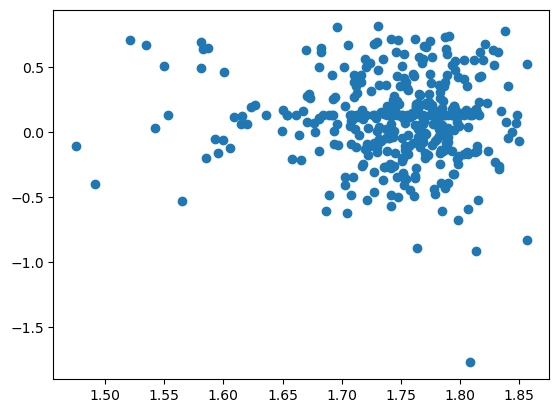

In [108]:
plot_gene_expression_vs_proteins('MAPT', 'ptau_ng_per_mg', protein_df_median_cleaned, rows_genes_df, gene_expression_df)



0.008451533369608799
[-0.46093253]


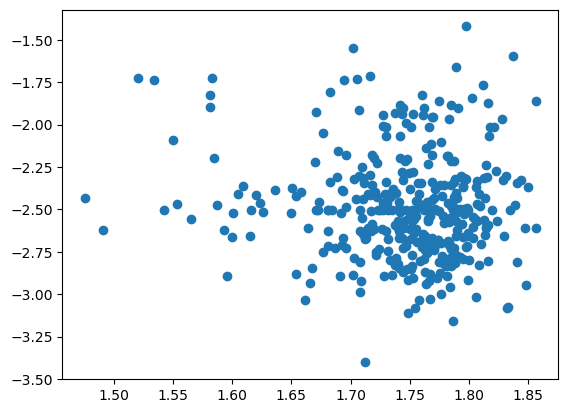

In [109]:
plot_gene_expression_vs_proteins('MAPT', 'ihc_tau2_ffpe', protein_df_median_cleaned, rows_genes_df, gene_expression_df)


0.0020927795182481557
[-0.25596627]


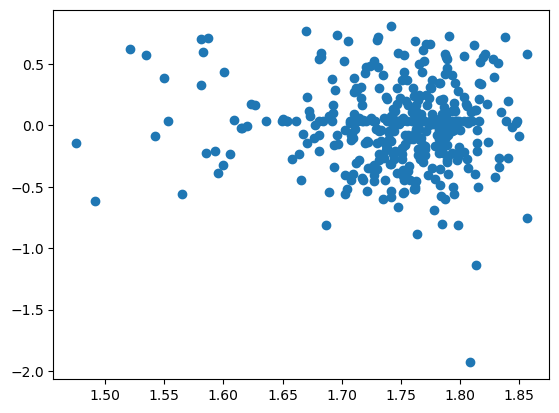

In [110]:
plot_gene_expression_vs_proteins('MAPT', 'ptau_over_tau_ratio', protein_df_median_cleaned, rows_genes_df, gene_expression_df)


0.0025183611394502536
[-0.46055569]


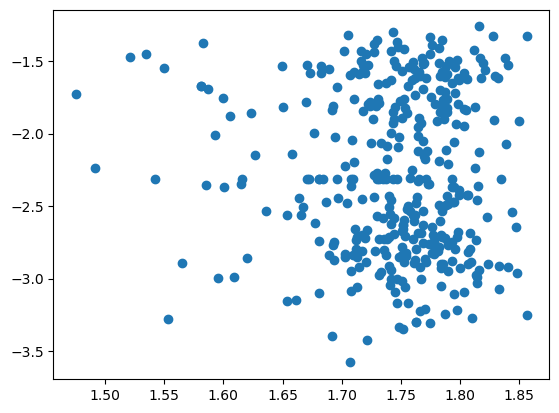

In [111]:
plot_gene_expression_vs_proteins('MAPT', 'ihc_at8_ffpe', protein_df_median_cleaned, rows_genes_df, gene_expression_df)


0.0020437661456436107
[-0.0579554]


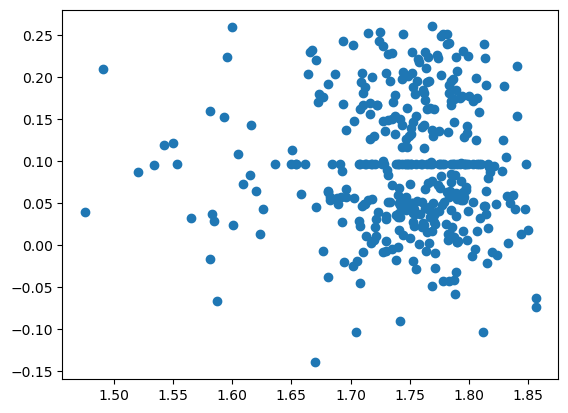

In [112]:
plot_gene_expression_vs_proteins('MAPT', 'tau_ng_per_mg', protein_df_median_cleaned, rows_genes_df, gene_expression_df)


In [114]:
# No correlation between gene expression and protein expression between MAPT and Tau